# Drops of Jupyter:  Making Maps with Python and Interactive Notebooks

**Ryan Cooper |  @maptastik**

Technology Analyst | Raleigh Parks, Recreation and Cultural Resources

Presentation Repo: https://github.com/maptastik/gisday_2019

1. What is a Jupyter Notebook?
2. Static Maps
3. Interactive Maps
4. Advanced Applications

## What is a Jupyter Notebook?

_The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text._ - [jupyter.org](https://jupyter.org/)

- Python
- R
- Julia
- and over 100 other languages

# THIS.

## Pandas + Shapely: A standard data model

In [80]:
import geopandas as gpd

### Read a file

In [81]:
parks_gdf = gpd.read_file('https://opendata.arcgis.com/datasets/43b5d6bf9d6e400599498d052545d331_0.geojson')

### View the data frame

In [ ]:
parks_gdf.head()

### Get information about the dataset

#### Fields

In [ ]:
parks_gdf.info()

#### Summay Statistics

In [ ]:
parks_gdf.describe()

In [ ]:
parks_gdf['DEVELOPED'].value_counts()

#### Geometry Properties

In [ ]:
parks_gdf.crs

In [ ]:
park_geometry = parks_gdf.loc[parks_gdf[parks_gdf["NAME"] == 'Brentwood'].index[0], 'geometry']
display(park_geometry)
print(f'Python Object Type: {type(park_geometry)}')
print(f'Geometry Type: {park_geometry.geom_type}')

In [ ]:
print(park_geometry)

#### Shapely Geometry

In [ ]:
park_geometry.centroid.x, park_geometry.centroid.y

In [ ]:
from pyproj import Proj, transform
inProj = Proj(init = 'epsg:4326')
outProj = Proj(init = 'epsg:2264')
x, y = transform(inProj, outProj, park_geometry.centroid.x, park_geometry.centroid.y)
x, y

In [ ]:
parks_points_gdf = parks_gdf.copy()
parks_points_gdf['geometry'] = parks_points_gdf.apply(lambda x: x['geometry'].centroid, axis = 1)
parks_points_gdf.plot()

## Static Maps

#### Plot geometries with geopandas

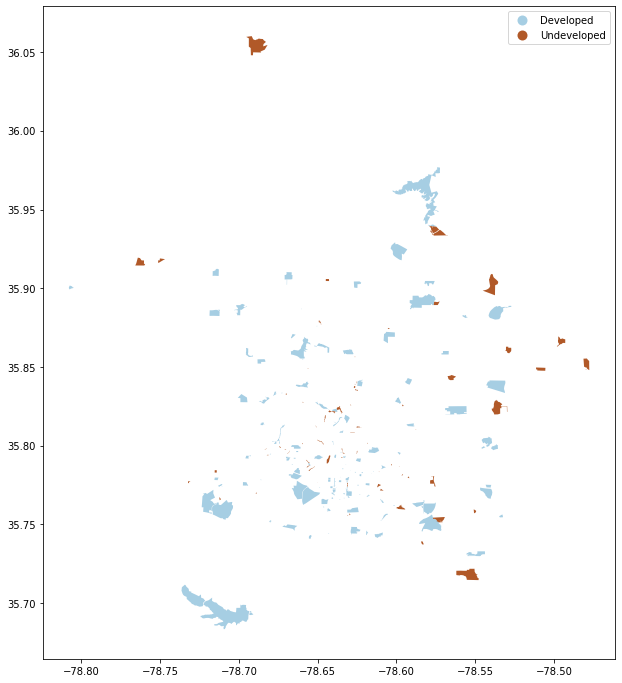

In [82]:
%matplotlib inline
parks_gdf.plot(column = 'DEVELOPED', cmap = 'Paired', figsize = (12, 12), legend = True)

### Example: Citrix Cycle Docks w/ geopandas and contextily

In [83]:
import requests
from io import BytesIO
import pandas as pd
from shapely.geometry import Point

#### Access Citrix Cycle Docks data feed

In [84]:
cc_docks_r = requests.get('https://citrixcycle.com/stations/stations/')
cc_docks_df = pd.read_json(BytesIO(cc_docks_r.content))
cc_docks_reduced_df = cc_docks_df.loc[:,['id', 'locking_station_type', 'description', 'address', 'primary_locked_cycle_count', 'stocking_low', 'total_locked_cycle_count', 'free_spaces', 'location']]
cc_docks_reduced_df['geometry'] = cc_docks_reduced_df.apply(lambda x: Point(x['location'][1],x['location'][0]), axis = 1)
cc_docks_reduced_df.drop(columns=['location'], inplace = True)
cc_docks_reduced_gdf = gpd.GeoDataFrame(cc_docks_reduced_df, geometry = 'geometry', crs={'init': 'epsg:4326'})
cc_docks_reduced_gdf.head()

,id,locking_station_type,description,address,primary_locked_cycle_count,stocking_low,total_locked_cycle_count,free_spaces,geometry
0,f8730a3b-4160-490a-8b85-02059fa3794a,PHYSICAL,Municipal Building,201 W Morgan St,3,1,7,4,POINT (-78.64312 35.77855)
1,7281d2a7-5dd8-49e8-94ec-5415cc2fc5aa,PHYSICAL,Citrix Station (W Morgan at S West),100 E West St,5,2,5,5,POINT (-78.64604 35.77953)
2,af572482-0095-44b0-8d74-480781aee83c,PHYSICAL,Duke Energy Center,2 E South St,12,3,12,5,POINT (-78.63971 35.77209)
3,fa9e203d-4de9-4686-8eb3-503246a5e8a9,PHYSICAL,Hillsborough & Dan Allen (Stanhope),2811 Hillsborough St,8,3,8,5,POINT (-78.67462 35.78911)
4,dad24dfb-004c-478a-a627-553519878d36,PHYSICAL,Jones & West (N West at W Jones),202 N West St,9,2,9,5,POINT (-78.64574 35.78283)


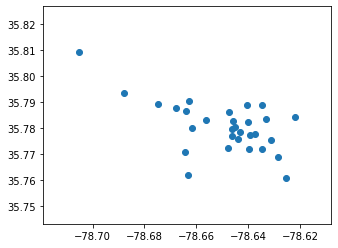

In [85]:
cc_docks_reduced_gdf.plot()

#### Plot with contextily

In [86]:
import contextily as ctx

In [ ]:
cc_ax1 = cc_docks_reduced_gdf.to_crs(epsg = 3857).plot(figsize = (12, 20))
ctx.add_basemap(cc_ax1, url = 'https://a.basemaps.cartocdn.com/rastertiles/voyager/{z}/{x}/{y}.png')

#### Size maker by column value

In [ ]:
cc_docks_reduced_gdf.describe()

In [ ]:
cc_ax2 =cc_docks_reduced_gdf.to_crs(epsg = 3857).plot(markersize = cc_docks_reduced_gdf['total_locked_cycle_count']**3, figsize = (12, 20))
ctx.add_basemap(cc_ax2, url = 'https://a.basemaps.cartocdn.com/rastertiles/voyager/{z}/{x}/{y}.png')

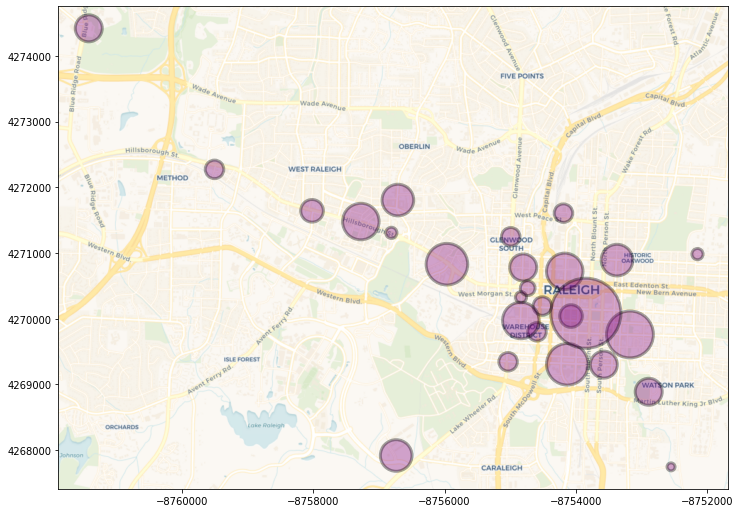

In [87]:
cc_ax3 = cc_docks_reduced_gdf.to_crs(epsg = 3857).plot(
    marker = 'o',
    markersize = cc_docks_reduced_gdf['total_locked_cycle_count']**3,
    color = 'purple',
    edgecolors = 'black',
    linewidths = 3,
    alpha = 0.35,
    figsize = (12,20)) 
ctx.add_basemap(cc_ax3, url = 'https://a.basemaps.cartocdn.com/rastertiles/voyager/{z}/{x}/{y}.png')

### Example: Plotting building permit density with geoplot

#### Access last month of Raleigh building permit data

In [88]:
bp_gdf = gpd.read_file('https://opendata.arcgis.com/datasets/f7a3cbd07e9f4ca5bb6637e7eeab5871_0.geojson')
# bp_gdf = gpd.read_file('./DATA/building_permits_1month.geojson')
bp_gdf.drop(bp_gdf[bp_gdf['geometry'].isna()].index, inplace = True)
bp_gdf.head()

,OBJECTID,permittypemapped,workclass,permitclass,proposedworkdescription,permitclassmapped,applieddate,issueddate,estprojectcost,constcompletedofficial,...,streettype,totalsqft,voiddate,workclassmapped,GlobalID,CreationDate,EditDate,const_type,permitnum,geometry
0,53702,Building,New Single Family Dwelling,101,SFD,Residential,2017-09-12T04:00:00,2019-10-08T20:44:37,381862.00,No,...,None,4002,None,Existing,473ebd18-adec-46aa-ab3e-5f1663e0425c,2018-03-16T01:55:55,2019-10-13T22:22:43,V B,143167,POINT (-78.58197 35.93729)
1,191154,Building,New Building,318,NEW BLDG/JOHN CHAVIS MEMORIAL PARK PH 1,Non-Residential,2019-09-10T04:00:00,2019-10-07T04:00:00,5659068.00,No,...,None,41601,None,Existing,a741975d-d9d4-4897-8377-1d1ed52375b3,2018-11-05T23:02:30,2019-10-11T22:23:50,None,153524,POINT (-78.62898 35.76943)
3,192051,Building,Addition,437,ADDITION TO EXISTING CAROUSEL,Non-Residential,2019-09-11T04:00:00,2019-10-07T23:36:31,13815.04,No,...,None,128,None,Existing,84f8523f-94a2-4e1e-af2e-76538ea89c47,2018-12-14T23:02:41,2019-10-11T22:23:50,None,154461,POINT (-78.62898 35.76943)
4,192052,Building,Alteration/Repairs,437,ALTERATION TO CAROUSEL HOUSE,Non-Residential,2019-09-11T04:00:00,2019-10-07T04:00:00,184123.00,No,...,None,2343,None,Existing,b85be180-2a95-4f24-b5df-727f4a7b027e,2018-12-14T23:02:41,2019-10-11T22:23:50,None,154460,POINT (-78.62898 35.76943)
5,192189,Building,Alteration/Repairs,320,ENSCO (ECK) SUPPLY-2539 NOBLIN ROAD-SUITE 106,Non-Residential,2019-09-10T04:00:00,2019-10-09T04:00:00,392425.00,No,...,None,7616,None,Existing,e50df212-7245-4d26-9ca2-dc39d5b62538,2018-12-21T23:02:39,2019-10-21T22:23:41,II B,154640,POINT (-78.59819 35.80821)


#### Plotting building permit density with geoplot

In [89]:
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

In [ ]:
bp_ax1 = gplt.pointplot(bp_gdf, projection = gcrs.WebMercator(), s = 8, color = 'green', figsize = (12, 12))
gplt.webmap(bp_gdf, provider = 'ST_TONER', ax = bp_ax1)

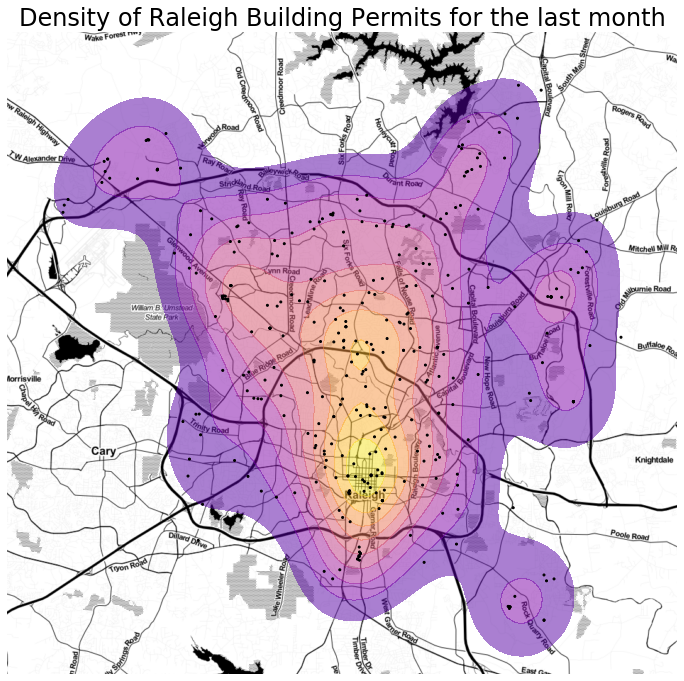

In [90]:
bp_ax2 = gplt.kdeplot(bp_gdf, projection = gcrs.WebMercator(), cmap = 'plasma', shade = True, alpha = 0.5, figsize = (12, 12))
gplt.pointplot(bp_gdf, s = 2, color = 'black', ax = bp_ax2)
gplt.webmap(bp_gdf, provider = 'ST_TONER', ax = bp_ax2)
plt.title("Density of Raleigh Building Permits for the last month", fontsize = 24)
fig = plt.gcf()

## Interactive

### Example: Interactive Choropleth

First, a data processing diversion...Aggregating points to a hexgrid!

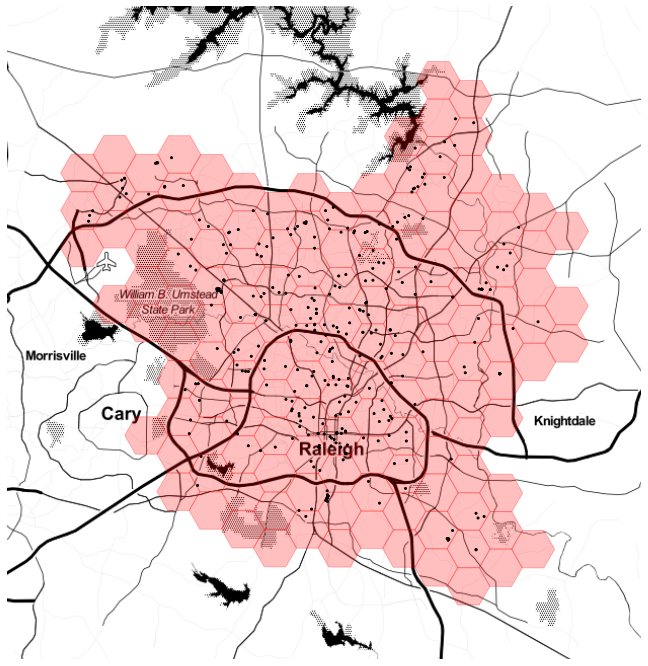

In [91]:
hexgrid_gdf = gpd.read_file('./DATA/hexgrid_polygon_4326.geojson')
hex_ax = gplt.polyplot(hexgrid_gdf, projection = gcrs.WebMercator(), color = 'red', alpha = 0.25, figsize = (12, 12), zorder = 1)
gplt.pointplot(bp_gdf, s = 2, color = 'black', ax = hex_ax, zorder = 2)
gplt.webmap(hexgrid_gdf, provider = 'ST_TONER', ax = hex_ax)

In [92]:
bp_hex_counts_df = gpd.sjoin(hexgrid_gdf, bp_gdf)['hexid'].value_counts().reset_index().rename(columns = {'index': 'hexid', 'hexid': 'bp_count'})
bp_hex_counts_gdf = hexgrid_gdf.merge(bp_hex_counts_df, on = 'hexid')
bp_hex_counts_gdf.head()

,hexid,geometry,bp_count
0,101,"MULTIPOLYGON (((-78.82279 35.90332, -78.81546 ...",3
1,105,"MULTIPOLYGON (((-78.80084 35.91358, -78.79350 ...",6
2,111,"MULTIPOLYGON (((-78.77893 35.90324, -78.77159 ...",1
3,112,"MULTIPOLYGON (((-78.77887 35.92385, -78.77153 ...",4
4,115,"MULTIPOLYGON (((-78.75734 35.78988, -78.75001 ...",2


#### Folium

In [93]:
import folium

In [94]:
m1 = folium.Map(location = [35.84, -78.638176], zoom_start = 12)
m1

In [95]:
m2 = folium.Map(
    location = [35.84, -78.638176], 
    zoom_start = 12,
    tiles = 'stamentoner')
folium.Choropleth(
    geo_data = './DATA/hexgrid_polygon_4326.geojson',
    name = 'Building Permit Hexbins',
    data = bp_hex_counts_df,
    columns = ['hexid', 'bp_count'],
    key_on = 'feature.properties.hexid',
    fill_color = 'Greens',
    fill_opacity = 0.75,
    highlight = True,
    nan_fill_opacity = 0,
    nan_fill_color = '#ffffff',
    line_weight = 0,
    control = True
).add_to(m2)

folium.LayerControl().add_to(m2)
m2

#### mapboxgl-jupyter

In [ ]:
token = 'pk.eyJ1IjoicHJjcmRldmxhYiIsImEiOiJjamljNWE0Z2owMGJjM2tzM3gxYmRrNXZnIn0.exFKTScPuDEIqeY-Rv36gQ'
from mapboxgl.viz import *
from mapboxgl.utils import *

In [ ]:
bp_count_json = gdf_to_geojson(
    bp_hex_counts_gdf,
    properties = ['hexid', 'bp_count']
)

viz = ChoroplethViz(bp_count_json,
                    access_token = token,
                    color_property = 'bp_count',
                    color_stops = create_color_stops([0,10,20], colors = 'Greens'),
                    line_width = 0,
                    opacity = 0.75,
                    center = (-78.638176, 35.84),
                    zoom = 11,
                    legend_layout = 'horizontal',
                    height = "600px"
                   )

display(viz.show())

#### CARTOframes

In [96]:
from cartoframes.viz.helpers import color_continuous_layer
color_continuous_layer(bp_hex_counts_gdf, 'bp_count', 'Building Permits')

In [ ]:
Map(
    Layer(
        bp_hex_counts_gdf,
        '''
        color: ramp(globalQuantiles($bp_count,8), teal)
        opacity: 0.75
        ''',
        legend = Legend(
            'color-bins',
            title = 'Building Permits',
            description = "by hex grid cell",
            footer = "City of Raleigh GIS"
        ),
        popup = Popup({
            'hover': {'title': 'Total Building Permits', 'value':'$bp_count'}
        })
    )
)

### Advanced Applications

But first, some combining GoRaleigh Stop and Shelter datasets...

In [97]:
def arcgis_rest_to_gdf(url, layer_id):
  url = f'{url}/{layer_id}/query'
  params = {
    'f': 'geojson',
    'where': '1=1',
    'outFields': '*',
    'outSR': 4326
  }
  r = requests.get(url, params = params)
  return gpd.read_file(BytesIO(r.content))

shelters_gdf = arcgis_rest_to_gdf("https://services.arcgis.com/v400IkDOw1ad7Yad/arcgis/rest/services/GoRaleigh_Shelters/FeatureServer", 0)
stops_gdf = arcgis_rest_to_gdf("https://services.arcgis.com/v400IkDOw1ad7Yad/ArcGIS/rest/services/GoRaleigh_Stops/FeatureServer", 0)

shelters_reduced_gdf = shelters_gdf.loc[:,["Stop_ID", "Stop_Name", "Shelter", "geometry"]]
shelters_reduced_gdf["Stop_ID"] = shelters_reduced_gdf.apply(lambda x: str(x["Stop_ID"]), axis = 1)
shelters_reduced_gdf["Status"] = shelters_reduced_gdf.apply(lambda x: "Planned" if "Planned" in x["Shelter"] else "Existing", axis = 1)
shelters_reduced_gdf["Shelter"] = shelters_reduced_gdf.apply(lambda x: x["Shelter"].split(' - ')[0], axis = 1)

stops_reduced_gdf = stops_gdf[["StopAbbr", "StopName", "geometry"]]
stops_reduced_gdf = stops_reduced_gdf.groupby("StopAbbr").first().reset_index()[["StopAbbr", "StopName", "geometry"]]

stops_shelters_gdf = stops_reduced_gdf.merge(shelters_reduced_gdf, how = 'outer', left_on = 'StopAbbr', right_on = 'Stop_ID', suffixes = ('', '_shelters'), sort = True)

# Clean up some of the fields and pivot Status field for use with formula widget
stops_shelters_gdf['StopAbbr'].fillna('0', inplace = True)
stops_shelters_gdf["StopName"].fillna("Unnamed Stop", inplace = True)
stops_shelters_gdf["Shelter"].fillna("No Shelter", inplace = True)
stops_shelters_gdf["Status"].fillna('No Shelter Planned', inplace = True)
stops_shelters_gdf["Existing"] = stops_shelters_gdf.apply(lambda x: 1 if x["Status"] == "Existing" else 0, axis = 1)
stops_shelters_gdf["Planned"] = stops_shelters_gdf.apply(lambda x: 1 if x["Status"] == "Planned" else 0, axis = 1)
stops_shelters_gdf["No_Shelter_Planned"] = stops_shelters_gdf.apply(lambda x: 1 if x["Status"] == "No Shelter Planned" else 0, axis = 1)
stops_shelters_gdf["geometry"] = stops_shelters_gdf.apply(lambda x: x["geometry_shelters"] if x["geometry"] is None else x["geometry"], axis = 1)

stops_shelters_gdf = stops_shelters_gdf[["StopAbbr", "StopName", "Shelter", "Status", "Existing", "Planned", "No_Shelter_Planned", "geometry"]]
stops_shelters_gdf = gpd.GeoDataFrame(stops_shelters_gdf, crs = {"init":"epsg:4326"}, geometry = "geometry")

In [98]:
stops_shelters_gdf.head()

,StopAbbr,StopName,Shelter,Status,Existing,Planned,No_Shelter_Planned,geometry
0,0,Unnamed Stop,ES,Planned,0,1,0,POINT (-78.69470 35.76832)
1,0,Unnamed Stop,ES,Planned,0,1,0,POINT (-78.69848 35.76683)
2,1201,Hillsborough St at Snow Ave,No Shelter,No Shelter Planned,0,0,1,POINT (-78.65174 35.78093)
3,1284,Wilmington St at Cabarrus St,No Shelter,No Shelter Planned,0,0,1,POINT (-78.63828 35.77433)
4,1293,Dawson St at Martin St,No Shelter,No Shelter Planned,0,0,1,POINT (-78.64359 35.77738)


#### CARTOframes

In [99]:
from cartoframes.viz import Map, Layer, Legend, Popup
from cartoframes.viz.widgets import category_widget, formula_widget

In [100]:
shelter_stop_map = Map(
    Layer(
        stops_shelters_gdf,
        '''
        color: ramp(buckets($Status, ["Existing", "Planned", "No Shelter Planned"]), [#4CAF50, #FFC107, #B0BEC533]),
        width: 5
        ''',
        legend = Legend(
            'color-category',
            title = "GoRaleigh Status of Bus Stop Shelters",
            footer = "Data: GoRaleigh, City of Raleigh"
        ),
        popup = Popup({
           'click': [{
                'title': 'Stop',
                'value':'$StopName'
               }, {
                'title': 'Shelter',
                'value': '$Shelter'
               }, {
                'title': 'Shelter Status',
                'value': '$Status'
               }
            ] 
        }),
        widgets = [
          formula_widget(
              'Existing',
              'sum',
              title = "Existing Bus Stop Shelters"
          ),
          formula_widget(
              'Planned',
              'sum',
              title = "Planned Bus Stop Shelters"
          ),
          formula_widget(
              'No_Shelter_Planned',
              'sum',
              title = "No Planned Bus Stop Shelters"
          ),
          category_widget(
              'Status',
              title = "Shelter Status",
              description = "Click to filter by shelter status"
          ),
          category_widget(
              'Shelter',
              title = "Shelter Type",
              description = "Click to filter by shelter Type"
          )
        ]
    )
)

In [101]:
shelter_stop_map

#### Kepler

In [102]:
from keplergl import KeplerGl

Before using Kepler, we'll do some data maniuplation to separate the bus stop coordinates into `x` and `y` columns.

In [ ]:
stops_shelters_xy_gdf = stops_shelters_gdf
stops_shelters_xy_gdf['x'] = stops_shelters_xy_gdf.apply(lambda x: x['geometry'].x, axis = 1)
stops_shelters_xy_gdf['y'] = stops_shelters_xy_gdf.apply(lambda x: x['geometry'].y, axis = 1)
stops_shelters_xy_gdf.head()

#### Bus Stop & Shelters

In [ ]:
map_1 = KeplerGl(
    height = 1000,
    data = {
        "bus": stops_shelters_xy_gdf
    }
)
map_1

#### Census Block - Park Connections

In [103]:
ebpa_df = pd.read_csv('./DATA/ebpa_all_los_origin_dest_201902.csv')
map_2_config = {'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': ['ebpa'],
     'id': 'rarxykf9',
     'name': ['analysis_class'],
     'type': 'range',
     'value': [0.5, 4],
     'enlarged': False,
     'plotType': 'histogram',
     'yAxis': None},
    {'dataId': ['ebpa'],
     'id': 'nbg2l08d7n',
     'name': ['total_length'],
     'type': 'range',
     'value': [0, 1000],
     'enlarged': False,
     'plotType': 'histogram',
     'yAxis': None}],
   'layers': [{'id': 'deygtuk',
     'type': 'arc',
     'config': {'dataId': 'ebpa',
      'label': 'ebpa',
      'color': [206, 64, 170],
      'columns': {'lat0': 'origin_y',
       'lng0': 'origin_x',
       'lat1': 'destination_y',
       'lng1': 'destination_x'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': [117, 222, 227]},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '4b4gt44',
     'type': 'geojson',
     'config': {'dataId': 'parks',
      'label': 'parks',
      'color': [77, 193, 156],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [119, 110, 87],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'ebpa': ['origin_id',
       'origin_x',
       'origin_y',
       'parkid',
       'destination_id'],
      'parks': ['OBJECTID',
       'NAME',
       'PARK_TYPE',
       'FILE_NUMBER',
       'PARCEL_COUNT']},
     'enabled': False},
    'brush': {'size': 0.5, 'enabled': True}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 24,
   'dragRotate': True,
   'latitude': 35.78332321445701,
   'longitude': -78.65892203437697,
   'pitch': 50,
   'zoom': 13.277939926587665,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [104]:
map_2 = KeplerGl(
    height = 600,
    data = {
        "ebpa": ebpa_df,
        "parks": parks_gdf
    }
)
map_2.config = map_2_config
map_2

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['ebpa'], 'id': 'rarxykf9', '…

In [105]:
map_2.config

{'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': 'ebpa',
     'id': 'l4n6b5njg',
     'name': 'total_length',
     'type': 'range',
     'value': [0, 5280],
     'enlarged': False,
     'plotType': 'histogram',
     'yAxis': None}],
   'layers': [{'id': 'deygtuk',
     'type': 'arc',
     'config': {'dataId': 'ebpa',
      'label': 'ebpa',
      'color': [206, 64, 170],
      'columns': {'lat0': 'origin_y',
       'lng0': 'origin_x',
       'lat1': 'destination_y',
       'lng1': 'destination_x'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': [117, 222, 227]},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 1